In [1]:
import time
import scipy
import numpy as np
import pandas as pd
import winsound

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData
from torch_geometric.nn import HGTConv, SAGEConv, GATConv, Linear, to_hetero

from HeteroDataFunctions import Encoder, complete_graph, flatten_lol, node_cat_dict, midi_type, plot_graph, plot_4graphs

# print(scipy.__version__)
# print(matplotlib.__version__)
# print(nx.__version__)
print(torch.__version__)

2.0.0+cu118


In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 960
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
# Load the complete graph
G = complete_graph(".\giantmidi-piano\edgelist")

loading edgelists...
- notes.edgelist
- program.edgelist
- tempo.edgelist
- time.signature.edgelist
Nodes: 286550
Edges: 2756865


In [4]:
nodes = pd.DataFrame((list(G.nodes)), columns=['name'])
edges = pd.DataFrame(np.array(list(G.edges)), columns=['source', 'target'])

In [5]:
matches = nodes['name'].str.match(r'^-?\d+(\.\d+)?$')

nodes[matches]

,name
286548,12


In [6]:
def node_cat_dict_giant(nodes: pd.DataFrame) -> dict:
    """Compile all nodes in the nodes Dataframe in a dictionary."""
    note_groups = [n for n in nodes['name'] if n[0] == 'g' and n[1] in [str(i) for i in range(10)] + ['-']]

    # not_group_nodes = [n for n in nodes['name'] if n not in note_groups]
    not_group_nodes = list(set(nodes['name']) - set(note_groups))

    url = [n for n in not_group_nodes if n[:4] == 'http']
    program_nodes = []
    note_nodes = []
    for u in url:
        if "programs" in u:
            program_nodes.append(u)
        elif "notes" in u:
            note_nodes.append(u)
        else:
            print(u)

    # name_nodes = [n for n in not_group_nodes if '_-_' in n]
    # dur_nodes = [n for n in not_group_nodes if n[:3] == 'dur']
    # vel_nodes = [n for n in not_group_nodes if n[:3] == 'vel']
    # time_nodes = [n for n in not_group_nodes if n[:4] == 'time']
    # tempo_nodes = list(set(not_group_nodes) - set(dur_nodes).union(vel_nodes, time_nodes, name_nodes, url))

    not_group_url_nodes = list(set(not_group_nodes) - set(url))
    name_nodes = []
    dur_nodes = []
    vel_nodes = []
    time_nodes = []
    tempo_nodes = []
    for n in not_group_url_nodes:
        if n[0] == '-' :
            name_nodes.append(n)
        elif n[:3] == 'dur':
            dur_nodes.append(n)
        elif n[:3] == 'vel':
            vel_nodes.append(n)
        elif n[:4] == 'time':
            time_nodes.append(n)
        else:
            tempo_nodes.append(n)

    node_categories = {"note_group": note_groups,
                       "pitch": note_nodes,
                       "program": program_nodes,
                       "MIDI": name_nodes,
                       "duration": dur_nodes,
                       "velocity": vel_nodes,
                       "time_sig": time_nodes,
                       "tempo": tempo_nodes
                       }
    return node_categories


In [7]:
node_categories = node_cat_dict_giant(nodes)
node_categories.keys()

dict_keys(['note_group', 'pitch', 'program', 'MIDI', 'duration', 'velocity', 'time_sig', 'tempo'])

In [8]:
nodes_df_complete = pd.read_csv('.\giantmidi-piano\complete_csv\\nodes_complete.csv')
edges_df_complete = pd.read_csv('.\giantmidi-piano\complete_csv\edges_complete.csv')
print('Done')

Done


In [9]:
nodes_df_complete

,Unnamed: 0,name,node_type
0,0,-Bach+_Johann_Sebastian+_Das_wohltemperierte_K...,MIDI
1,1,g1695254,note_group
2,2,http://purl.org/midi-ld/notes/77,pitch
3,3,dur:2,duration
4,4,vel:6,velocity
...,...,...,...
286545,286545,g952353344,note_group
286546,286546,g-549989140,note_group
286547,286547,http://purl.org/midi-ld/programs/0,program
286548,286548,12,tempo


In [10]:
list(set(edges_df_complete['edge_type']))

['note_group__has__velocity',
 'note_group__has__duration',
 'MIDI__has__tempo',
 'MIDI__has__program',
 'note_group__contains__pitch',
 'MIDI__has__note_group',
 'MIDI__in__time_sig']

In [11]:
node_types = set(nodes_df_complete['node_type'])
node_types

{'MIDI',
 'duration',
 'note_group',
 'pitch',
 'program',
 'tempo',
 'time_sig',
 'velocity'}

In [12]:
edge_types = ["MIDI__has__tempo",
              "MIDI__in__time_sig",
              "MIDI__has__program",
              "MIDI__has__note_group",
              "note_group__has__velocity",
              "note_group__has__duration",
              "note_group__contains__pitch"]

In [13]:
names_list = flatten_lol(node_categories.values())

In [14]:
encoder = Encoder(names_list, n_labels=15)

In [15]:
input_node_dict = {node_type: {'x': encoder.
                    encode_nodes(nodes_df_complete.
                    loc[nodes_df_complete['node_type'] == node_type, ['name']])}
                    for node_type in node_types}

encode_nodes took 10.22 secs to run
encode_nodes took 0.00 secs to run
encode_nodes took 0.00 secs to run
encode_nodes took 0.00 secs to run
encode_nodes took 0.00 secs to run
encode_nodes took 0.03 secs to run
encode_nodes took 0.00 secs to run
encode_nodes took 0.00 secs to run


In [16]:
node_enc_to_idx = {node_type: {encoder.decode_value(node_enc.item()): i for i, node_enc in enumerate(input_node_dict[node_type]['x'])} for node_type in node_types}

In [17]:
input_edge_dict = dict()
for edge_type in edge_types:
    node_type_s, node_type_t = edge_type.split('__')[0], edge_type.split('__')[2]

    edge_df = edges_df_complete.loc[edges_df_complete['edge_type'] == edge_type, ['source', 'target']].copy()

    edge_df['source'], edge_df['target'] = edge_df['source'].map(node_enc_to_idx[node_type_s]), edge_df['target'].map(node_enc_to_idx[node_type_t])

    input_edge_dict[edge_type] = {'edge_index': torch.tensor(edge_df.values).T}


In [18]:
# Extract the label of each Midi.
midi_val = nodes_df_complete.loc[nodes_df_complete['node_type'] == 'MIDI', ['name']].values

In [19]:
def midi_composer(midi_name: str) -> str:
        return midi_name.split('+_')[0].replace('-', "")


In [20]:
midi_classes = [midi_composer(s[0]) for s in midi_val]


In [21]:
lb = LabelEncoder()
y = torch.from_numpy(lb.fit_transform(midi_classes)) # .type(torch.LongTensor)

lb.classes_

array(['Bach', 'Beethoven', 'Carbajo', 'Chopin', 'Czerny', 'Handel',
       'Haydn', 'Liszt', 'Mozart', 'Rebikov', 'Satie', 'Scarlatti',
       'Schubert', 'Scriabin', 'Simpson'], dtype='<U9')

In [22]:
input_node_dict['MIDI']['y'] = y


In [23]:
H = HeteroData(input_node_dict, **input_edge_dict).to(device)

In [24]:
print(H)

HeteroData(
  note_group={ x=[285642, 1] },
  program={ x=[1, 1] },
  pitch={ x=[84, 1] },
  time_sig={ x=[1, 1] },
  tempo={ x=[1, 1] },
  MIDI={
    x=[750, 1],
    y=[750]
  },
  velocity={ x=[10, 1] },
  duration={ x=[61, 1] },
  (MIDI, has, tempo)={ edge_index=[2, 750] },
  (MIDI, in, time_sig)={ edge_index=[2, 750] },
  (MIDI, has, program)={ edge_index=[2, 750] },
  (MIDI, has, note_group)={ edge_index=[2, 953329] },
  (note_group, has, velocity)={ edge_index=[2, 434069] },
  (note_group, has, duration)={ edge_index=[2, 285658] },
  (note_group, contains, pitch)={ edge_index=[2, 1081559] }
)


In [25]:
# To enable 2-way message passing
H = T.ToUndirected()(H)

In [26]:
H = T.RandomNodeSplit(num_val=0.1, num_test=0.2)(H)

In [27]:
print(H)

HeteroData(
  note_group={ x=[285642, 1] },
  program={ x=[1, 1] },
  pitch={ x=[84, 1] },
  time_sig={ x=[1, 1] },
  tempo={ x=[1, 1] },
  MIDI={
    x=[750, 1],
    y=[750],
    train_mask=[750],
    val_mask=[750],
    test_mask=[750]
  },
  velocity={ x=[10, 1] },
  duration={ x=[61, 1] },
  (MIDI, has, tempo)={ edge_index=[2, 750] },
  (MIDI, in, time_sig)={ edge_index=[2, 750] },
  (MIDI, has, program)={ edge_index=[2, 750] },
  (MIDI, has, note_group)={ edge_index=[2, 953329] },
  (note_group, has, velocity)={ edge_index=[2, 434069] },
  (note_group, has, duration)={ edge_index=[2, 285658] },
  (note_group, contains, pitch)={ edge_index=[2, 1081559] },
  (tempo, rev_has, MIDI)={ edge_index=[2, 750] },
  (time_sig, rev_in, MIDI)={ edge_index=[2, 750] },
  (program, rev_has, MIDI)={ edge_index=[2, 750] },
  (note_group, rev_has, MIDI)={ edge_index=[2, 953329] },
  (velocity, rev_has, note_group)={ edge_index=[2, 434069] },
  (duration, rev_has, note_group)={ edge_index=[2, 285658]

# GNN

In [84]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, drop_layer: bool=False, drop_rate: float=0.5):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), hidden_channels)
        self.lin = Linear(-1, out_channels)
        self.drop = drop_layer
        self.drop_rate = drop_rate

    def forward(self, x, edge_index):
        if self.drop:
            x = F.dropout(x, p=self.drop_rate, training=self.training)
            x = self.conv1(x, edge_index).relu()
            x = F.dropout(x, p=self.drop_rate, training=self.training)
            x = self.conv2(x, edge_index).relu()

        else:
            x = self.conv1(x, edge_index).relu()
            x = self.conv2(x, edge_index)

        return x

    def _init_weights(self):
        # Custom weight initialization
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.zeros_(self.conv1.bias)

        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.zeros_(self.conv2.bias)

        nn.init.xavier_normal_(self.lin.weight)
        nn.init.zeros_(self.lin.bias)



model = GCN(hidden_channels=64, out_channels=len(set(lb.classes_)), drop_layer=False, drop_rate = .5)
model = to_hetero(model, H.metadata(), aggr='sum')
model.to(device)

GraphModule(
  (conv1): ModuleDict(
    (MIDI__has__tempo): SAGEConv((-1, -1), 64, aggr=mean)
    (MIDI__in__time_sig): SAGEConv((-1, -1), 64, aggr=mean)
    (MIDI__has__program): SAGEConv((-1, -1), 64, aggr=mean)
    (MIDI__has__note_group): SAGEConv((-1, -1), 64, aggr=mean)
    (note_group__has__velocity): SAGEConv((-1, -1), 64, aggr=mean)
    (note_group__has__duration): SAGEConv((-1, -1), 64, aggr=mean)
    (note_group__contains__pitch): SAGEConv((-1, -1), 64, aggr=mean)
    (tempo__rev_has__MIDI): SAGEConv((-1, -1), 64, aggr=mean)
    (time_sig__rev_in__MIDI): SAGEConv((-1, -1), 64, aggr=mean)
    (program__rev_has__MIDI): SAGEConv((-1, -1), 64, aggr=mean)
    (note_group__rev_has__MIDI): SAGEConv((-1, -1), 64, aggr=mean)
    (velocity__rev_has__note_group): SAGEConv((-1, -1), 64, aggr=mean)
    (duration__rev_has__note_group): SAGEConv((-1, -1), 64, aggr=mean)
    (pitch__rev_contains__note_group): SAGEConv((-1, -1), 64, aggr=mean)
  )
  (conv2): ModuleDict(
    (MIDI__has__tempo

In [85]:
optimizer_name = "Adam"
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [86]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(H.x_dict, H.edge_index_dict)
    mask = H['MIDI'].train_mask
    loss = F.cross_entropy(out['MIDI'][mask], H['MIDI'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)

In [87]:
@torch.no_grad()
def test():
    model.eval()
    pred = model(H.x_dict, H.edge_index_dict)['MIDI'].argmax(dim=-1)

    accs = []

    for mask in [H['MIDI'].train_mask, H['MIDI'].val_mask, H['MIDI'].test_mask]:
        accs.append(int((pred[mask] == H['MIDI'].y[mask]).sum()) / int(mask.sum()))
    return accs

In [88]:
with torch.no_grad():  # Initialize lazy modules.
     out = model(H.x_dict, H.edge_index_dict)

In [89]:
acc_lists = {'train': [], 'val': [], 'test': []}
loss_list = []

for epoch in range(1, 801):
    loss = train()
    train_acc, val_acc, test_acc = test()

    loss_list.append(loss)

    acc_lists['train'].append(train_acc)
    acc_lists['val'].append(val_acc)
    acc_lists['test'].append(test_acc)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 1096784.6250, Train: 0.0705, Val: 0.0533, Test: 0.0600
Epoch: 002, Loss: 517309.3125, Train: 0.0610, Val: 0.0533, Test: 0.0867
Epoch: 003, Loss: 390456.6250, Train: 0.0667, Val: 0.1067, Test: 0.0467
Epoch: 004, Loss: 530355.6250, Train: 0.0724, Val: 0.0667, Test: 0.0467
Epoch: 005, Loss: 575873.8125, Train: 0.0648, Val: 0.0267, Test: 0.0933
Epoch: 006, Loss: 792482.8750, Train: 0.0838, Val: 0.0533, Test: 0.0667
Epoch: 007, Loss: 1008054.0625, Train: 0.0895, Val: 0.0933, Test: 0.0933
Epoch: 008, Loss: 1329523.6250, Train: 0.0705, Val: 0.0667, Test: 0.0533
Epoch: 009, Loss: 1641804.5000, Train: 0.1371, Val: 0.1333, Test: 0.1200
Epoch: 010, Loss: 1903814.1250, Train: 0.0724, Val: 0.1467, Test: 0.0800
Epoch: 011, Loss: 2263919.7500, Train: 0.0762, Val: 0.0800, Test: 0.0733
Epoch: 012, Loss: 2340683.2500, Train: 0.0648, Val: 0.0667, Test: 0.0733
Epoch: 013, Loss: 2584894.2500, Train: 0.0648, Val: 0.0667, Test: 0.0733
Epoch: 014, Loss: 2290910.0000, Train: 0.0648, Val: 0.04

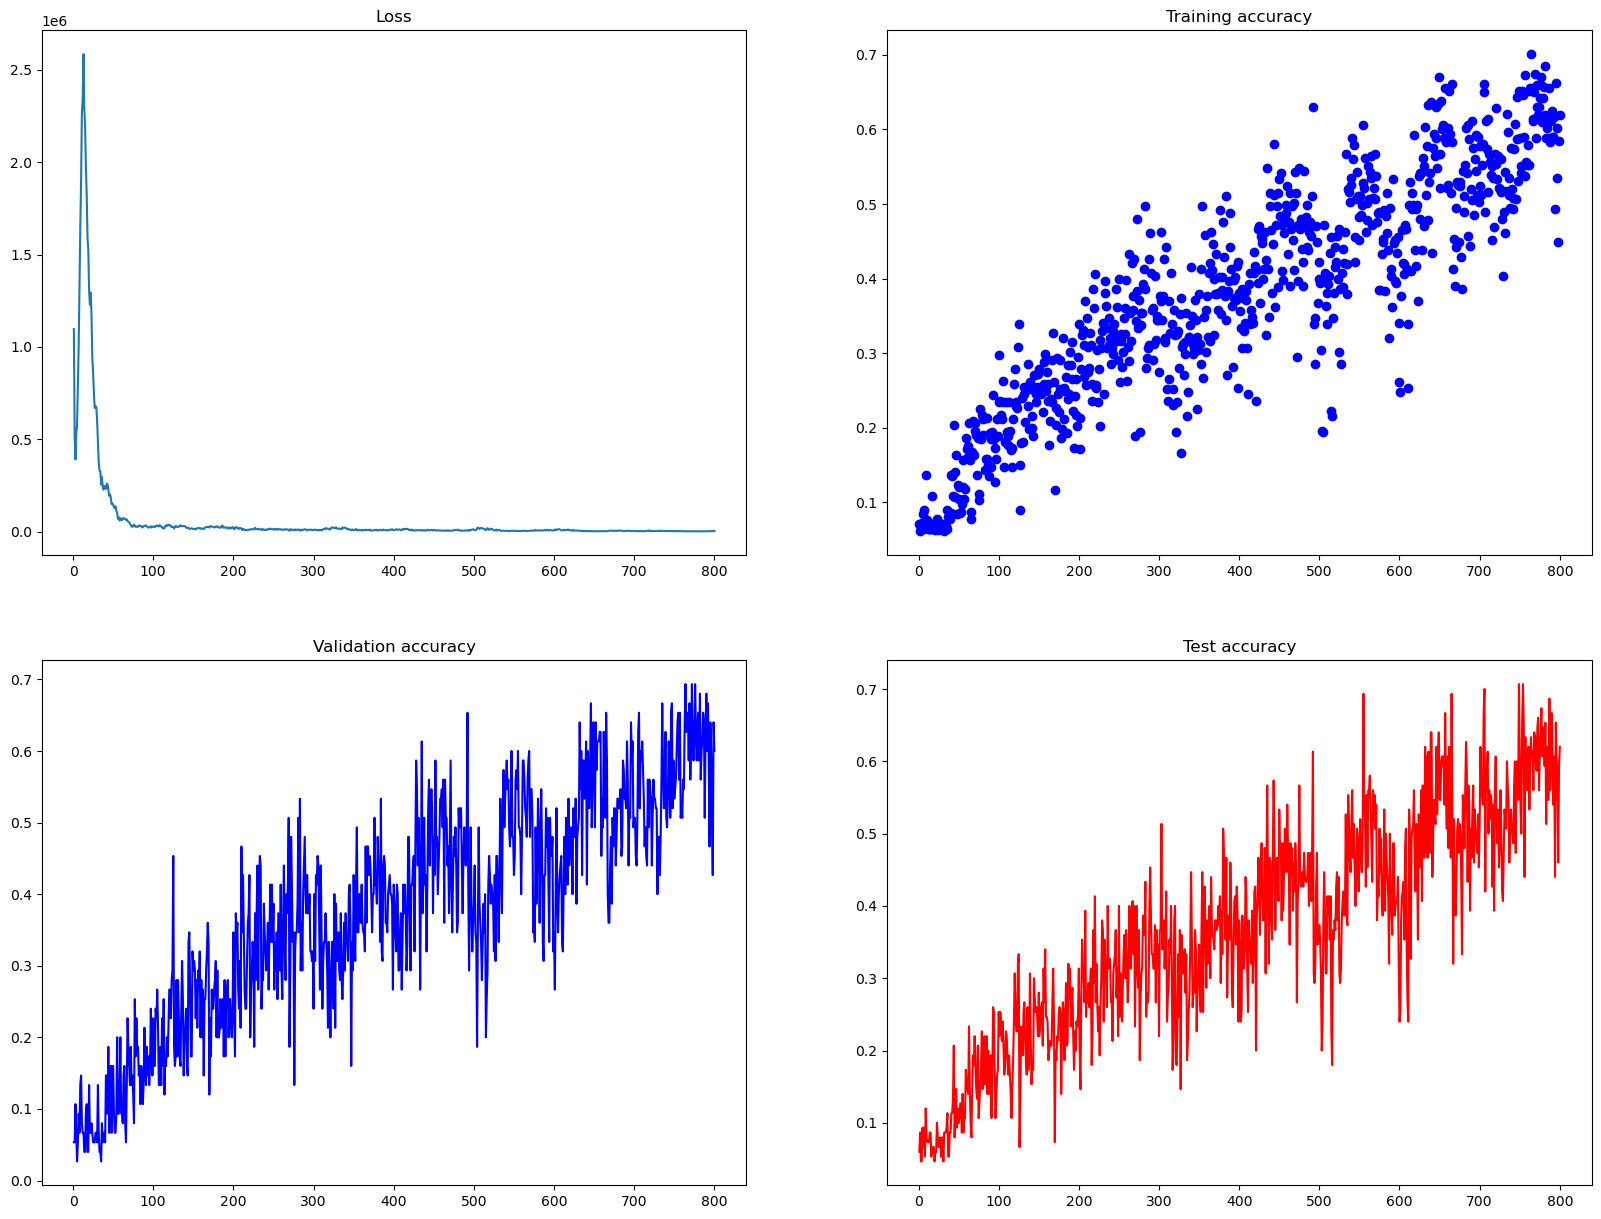

In [90]:
plot_4graphs(loss_list, acc_lists)

In [91]:
mask = H['MIDI'].test_mask

predicted = model(H.x_dict, H.edge_index_dict)['MIDI'].argmax(dim=-1)[mask]

predicted

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
         2,  2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  0,  0,  4,  0,  8,
         8,  4,  4,  4,  4,  4,  4,  0,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         7,  7,  7,  7,  7,  7,  7,  7,  8,  8, 14, 14,  9,  8,  8,  8,  9,  9,
         7,  9,  7,  9,  9,  9,  9, 12, 12, 12, 11, 12, 11, 12, 12, 12, 12, 12,
        11, 11, 11, 12, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 14, 12, 14, 12, 14, 12, 14, 14, 13, 14, 13, 13, 13,
        14, 14, 14, 14, 14, 13], device='cuda:0')

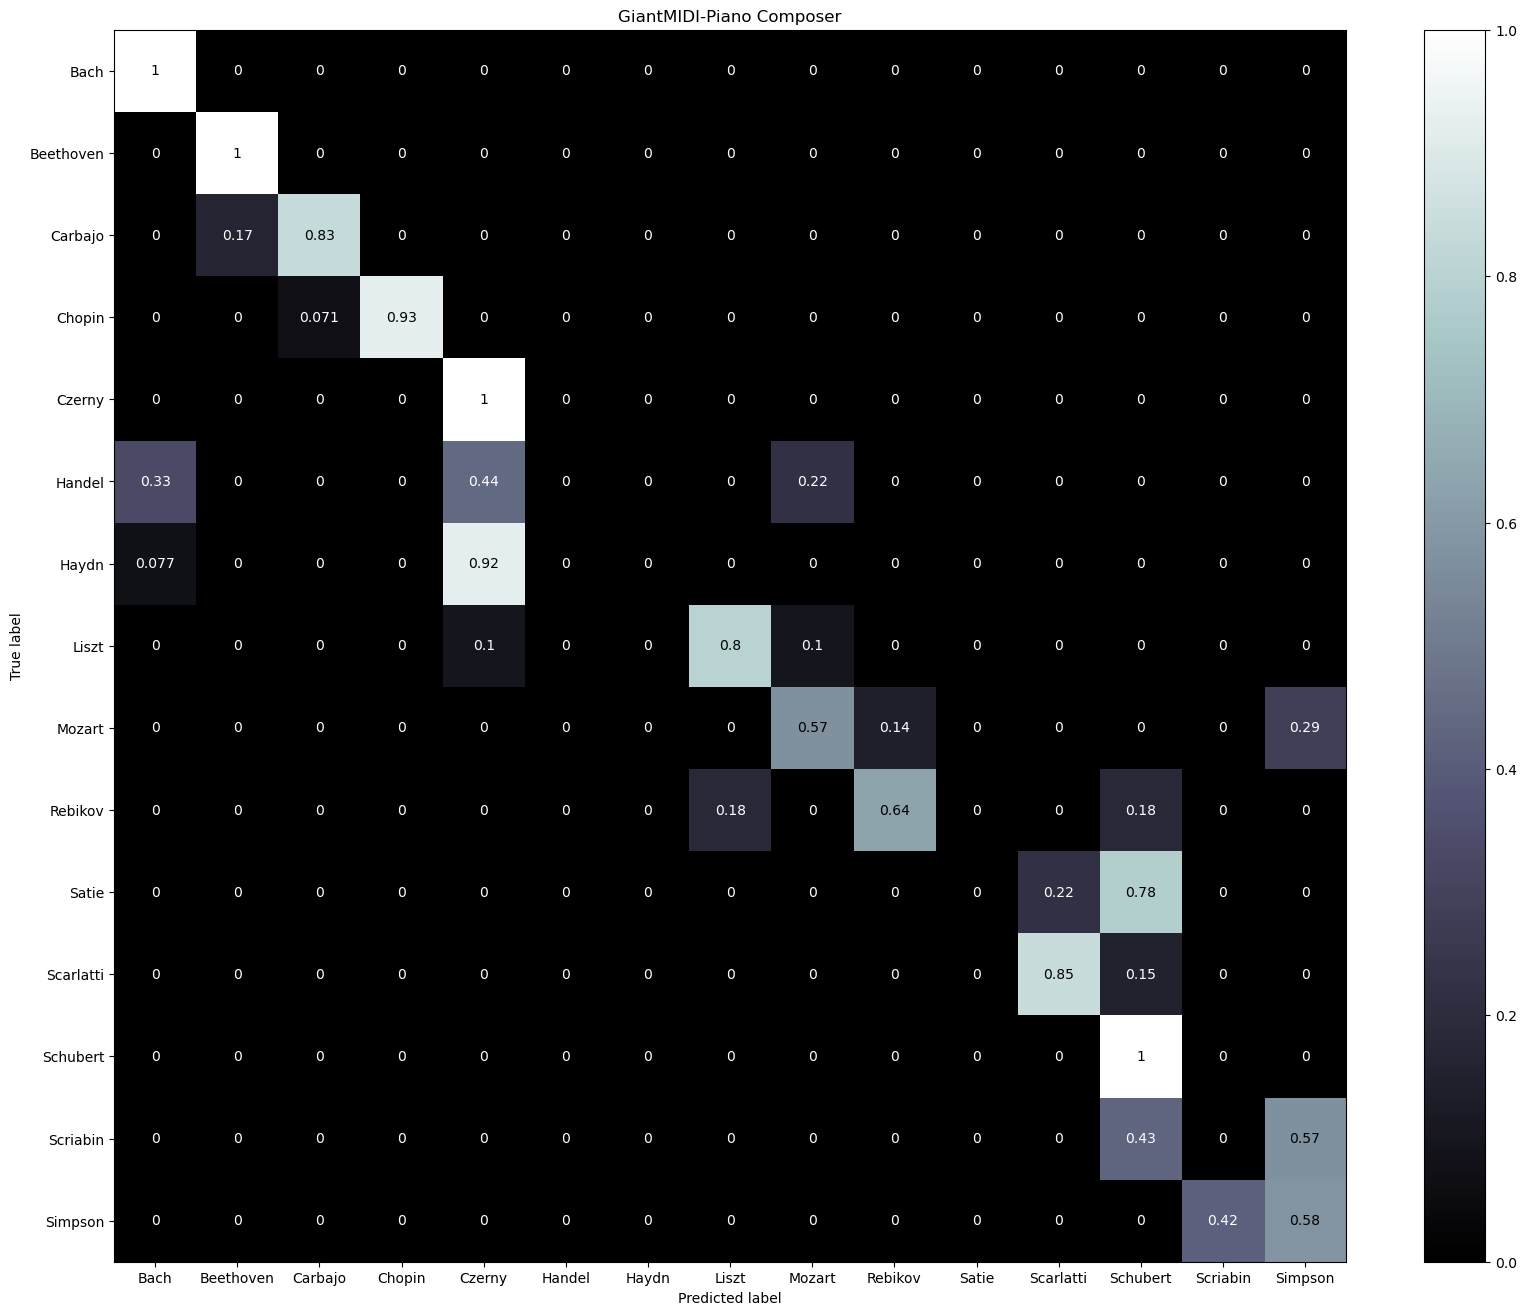

In [92]:

disp = ConfusionMatrixDisplay.from_predictions(y_true=lb.inverse_transform(H['MIDI'].y[mask].to('cpu')), y_pred=lb.inverse_transform(predicted.to('cpu')), cmap='bone', normalize='true')

disp.figure_.set_size_inches(20, 16)
disp.ax_.set_title('GiantMIDI-Piano Composer')

disp.figure_.savefig(".\giantmidi-piano\giantmidi_conf_matrix1.png")
plt.show()

In [93]:
winsound.Beep(400, 700)